# Resources used

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yellowbrick
from yellowbrick.model_selection import LearningCurve
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, GridSearchCV

import sklearn
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
print(f"shap: v {shap.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"yellowbrick: v {yellowbrick.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12

shap: v 0.47.0
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
matplotlib: v 3.6.2
yellowbrick: v 1.5
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Exploratory data analisys

## Data collection

In [3]:
df = pd.read_csv('数据时间导出.csv')  # 47 features
df = df.rename(columns={'VD0000':'impl_spd2',  # Main fan speed [rps]
                        'VD0008':'pump_spd',  # Peristaltic pump rotation speed [rps]
                        'VD0012':'I',  # Current [A]
                        'VD0016':'V',  # Voltage [V]
                        'VD0020':'W',  # Power [Wt]
                        'VD0028':'Q_CH4',  # CH4 flow rate [m3/h]
                        'VD0032':'impl_spd1',  # Cooling fan speed [rps]
                        'VD0036':'Q_CH4_N2',  #CH4/N2 flow rate [m3/h]
                        'VD0040':'P_NG',  # Differential natural gas pressure [bar]
                        'VD44':'O2',  # Inlet air oxygen concentration [%]
                        'VD208':'T3',  # bottom of the burner temperature [°C]
                        'VD212':'T4',  # top of the burner temperature [°C]
                        'VD216':'T5',  # inlet of the reformer temperature [°C]
                        'VD224':'T7',  # exhaust gases from the SOFC temperature [°C]
                        'VD232':'T9',  # heat exchanger temperature [°C]
                        'VD244':'T12',  # water temperature for steam reforming [°C]
                        'VD260':'T16',  # left front point of the SOFC temperature [°C]
                        'VD264':'T17',  # right rear point of the SOFC temperature [°C]
                        'VD272':'T19',  # air at the inlet of the SOFC temperature [°C]
                        'VD276':'T20',  # hydrogen at the inlet of the SOFC temperature [°C]
                        'VD280':'T21',  # air at the outlet of the SOFC temperature [°C]
                        'VD284':'T22',  # hydrogen at the outlet of the SOFC temperature [°C]
                        'VD288':'T23',  # top rear point of the reformer temperature [°C]
                        'VD292':'T24',  # bottom rear point of the reformer temperature [°C]
                        'VD296':'T25',  # top left point of the reformer temperature [°C]
                        'VD300':'T26',  # bottom left point of the reformer temperature [°C]
                        'VD304':'T27',  # top right point of the reformer temperature [°C]
                        'VD308':'T28',  # bottom right point of the reformer temperature [°C]
                        'VD316':'T30',  # cooling water temperature [°C]
                        'VD320':'T31'})  # water tank temperature [°C]

df.MCGS_TIME = pd.to_datetime(df.MCGS_TIME)
df = df.set_index('MCGS_TIME')
df = df.drop(columns=['MCGS_TIMEMS', 'VD48', 'VD0004', 'VD0024'])  # drop 4 useless features
df = df[df.columns[(abs(df.mean()-3000)>0.1)]]  # filtering 12 incorrect sensor readings
df = df[df.T17 != 3000]  # remove 92 lines with incorrect T17-value
df = df[df.V != 0]  # remove 18324 lines with zero target feature

# combine similar features (-4)
df.T3 = df[['T3', 'T4']].mean(axis=1)
df.T23 = df[['T23', 'T24']].mean(axis=1)
df.T25 = df[['T25', 'T26']].mean(axis=1)
df.T27 = df[['T27', 'T28']].mean(axis=1)
df = df.drop(columns=['T4', 'T24', 'T26', 'T28'])

# move the voltage to the end position (for correlation matrix)
V = df.V
df = df.drop('V', axis=1)
df['V'] = V

df.to_excel(f'DATA.xlsx')

print(df.info())
df.iloc[5480:5490, :]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14427 entries, 2024-04-23 19:20:09 to 2025-02-14 22:20:00
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   impl_spd2  14427 non-null  float64
 1   I          14427 non-null  float64
 2   pump_spd   14427 non-null  float64
 3   W          14427 non-null  float64
 4   Q_CH4      14427 non-null  float64
 5   impl_spd1  14427 non-null  float64
 6   Q_CH4_N2   14427 non-null  float64
 7   P_NG       14427 non-null  float64
 8   T3         14427 non-null  float64
 9   T5         14427 non-null  float64
 10  T7         14427 non-null  float64
 11  T9         14427 non-null  float64
 12  T12        14427 non-null  float64
 13  T16        14427 non-null  float64
 14  T17        14427 non-null  float64
 15  T19        14427 non-null  float64
 16  T20        14427 non-null  float64
 17  T21        14427 non-null  float64
 18  T22        14427 non-null  float64
 19  T23        

,impl_spd2,I,pump_spd,W,Q_CH4,impl_spd1,Q_CH4_N2,P_NG,T3,T5,...,T20,T21,T22,T23,T25,T27,T30,T31,O2,V
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2024-04-25 17:09:57,11.000004,0.00,20.0,0.000,1.915943,6.0,5.971296,0.012215,874.949982,552.900024,...,667.599976,684.299988,618.700012,569.799988,630.149994,677.850006,66.199997,52.599998,12.0000,40.500000
2024-04-25 17:10:27,11.000004,0.03,20.0,1.218,1.797853,6.0,5.969877,0.012210,888.649994,552.799988,...,668.099976,684.299988,618.599976,570.349976,632.100006,682.500000,66.099998,52.599998,10.9375,40.599998
2024-04-25 17:10:57,11.000004,0.03,20.0,1.221,0.000099,6.0,6.114091,0.013080,829.799988,552.799988,...,668.900024,684.299988,618.599976,570.750000,634.450012,686.800018,66.000000,52.599998,11.0000,40.700001
2024-04-25 17:11:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.180676,0.013943,791.750000,552.799988,...,669.599976,684.299988,618.599976,570.899994,636.500000,688.549988,66.000000,52.599998,12.8125,40.599998
2024-04-25 17:11:57,11.000004,0.03,20.0,1.212,0.000099,6.0,5.873411,0.013312,780.850006,552.799988,...,670.299988,684.299988,618.700012,570.950012,637.199982,688.299988,66.000000,52.599998,13.4375,40.400002
2024-04-25 17:12:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.007771,0.013530,774.299988,552.799988,...,670.700012,684.299988,618.799988,570.750000,637.299988,687.399994,65.900002,52.599998,13.7500,40.599998
2024-04-25 17:12:57,11.000004,0.03,20.0,1.215,0.000099,6.0,5.960526,0.013125,771.300018,552.900024,...,670.900024,684.299988,619.000000,570.750000,636.950012,686.350006,65.900002,52.599998,13.8750,40.500000
2024-04-25 17:13:27,11.000004,0.03,20.0,1.215,0.000099,6.0,6.058997,0.013146,769.399994,552.799988,...,670.900024,684.299988,619.099976,570.549988,636.449982,685.350006,65.900002,52.500000,14.0000,40.500000
2024-04-25 17:13:57,11.000004,0.03,20.0,1.080,0.000099,6.0,5.957923,0.013148,766.700012,552.799988,...,670.900024,684.299988,619.299988,570.450012,635.899994,684.549988,65.900002,52.500000,14.0000,36.000000


## Correlation matrix of initial features

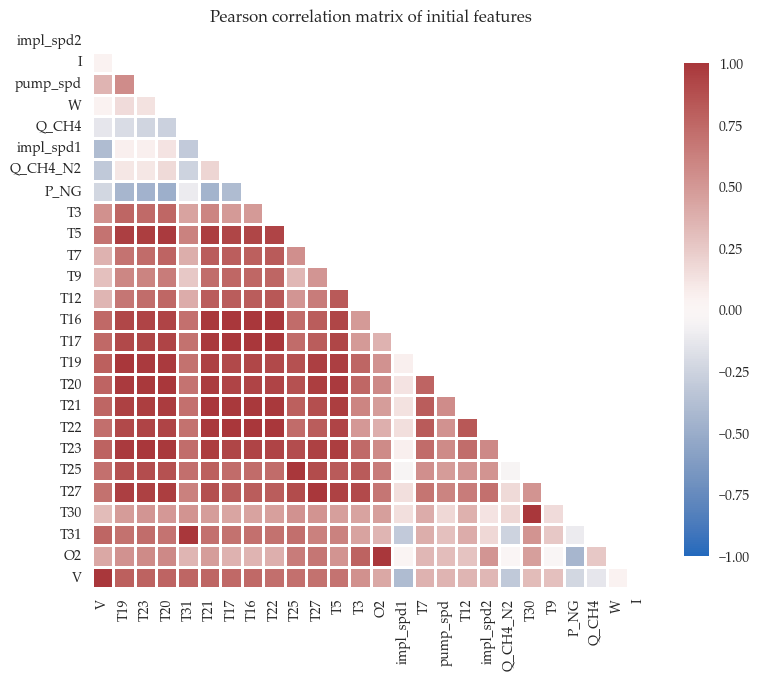

In [8]:
df_corr = df.corr('pearson')

# Let's sort column B by correlation strength (absolute value)
df_corr.sort_values(by='V', axis='columns', ascending=False, inplace=True, key=lambda col: abs(col))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, 
            #annot=True, 
            mask=mask, 
            cmap=sns.color_palette("vlag", as_cmap=True), 
            fmt=".3f", 
            vmax=1.0, 
            vmin=-1.0, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .8}).set(title='Pearson correlation matrix of initial features')

plt.savefig('pictures/full_corr_matrix.png', dpi = 300, transparent = True)
#df_corr.style.background_gradient(cmap=sns.color_palette("vlag", as_cmap=True), vmin = -1, vmax=1)  # output table-factor

## Data preprocessing

In [10]:
X = df.drop(columns='V').copy()  # input feature
y = df.V.copy()  # target feature (Voltage [V])

# Standardization of input feature general set 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

## Feature important

In [57]:
objective='reg:squaredlogerror'
n = 10  # desired count of components

перерисовать графики feature importance (Box plot)

### XGBoost features importance (MDI)

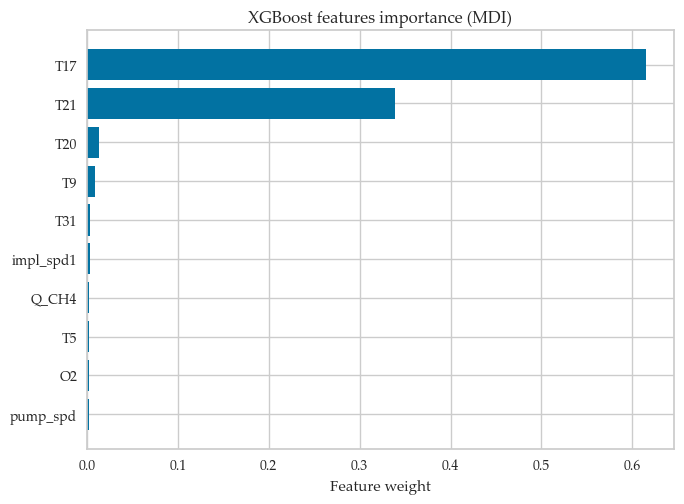

,importance
pump_spd,0.002022
O2,0.002240
T5,0.002737
Q_CH4,0.002756
impl_spd1,0.002952
T31,0.003354
T9,0.008812
T20,0.013796
T21,0.338410
T17,0.615026


In [58]:
selector = xgb.XGBRegressor(objective=objective, eval_metric='mape', random_state=42)
selector.fit(X_std, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/standard_feature_important.png', dpi = 300, transparent = True)
plt.title('XGBoost features importance (MDI)')
plt.show()

feature_importances

### Permutation Importance (PI)

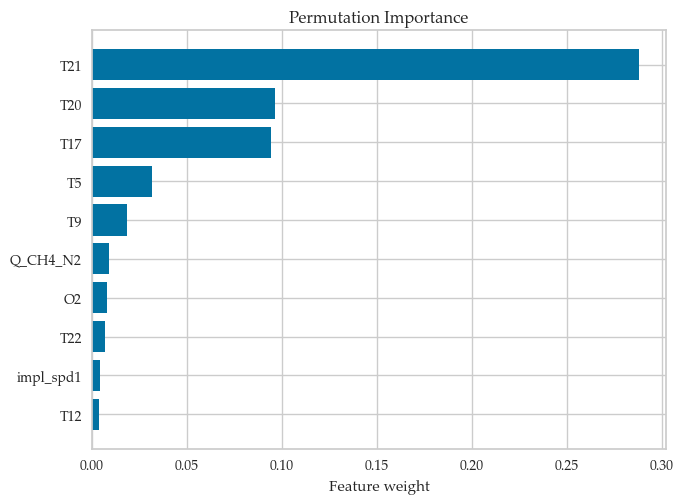

,importance
T12,0.003860
impl_spd1,0.004506
T22,0.007067
O2,0.007996
Q_CH4_N2,0.009256
T9,0.018598
T5,0.031860
T17,0.094404
T20,0.096523
T21,0.288100


In [59]:
feature_importances = pd.DataFrame(
    {'importance' : permutation_importance(selector, X_std, y, n_repeats=5, random_state=42, n_jobs=-1).importances_mean},
    index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get 10 strongest features

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/Permutation_Importance.png', dpi = 300, transparent = True)
plt.title('Permutation Importance')
plt.show()

feature_importances

### SHapley Additive exPlanations (SHAP)

<function matplotlib.pyplot.show(close=None, block=None)>

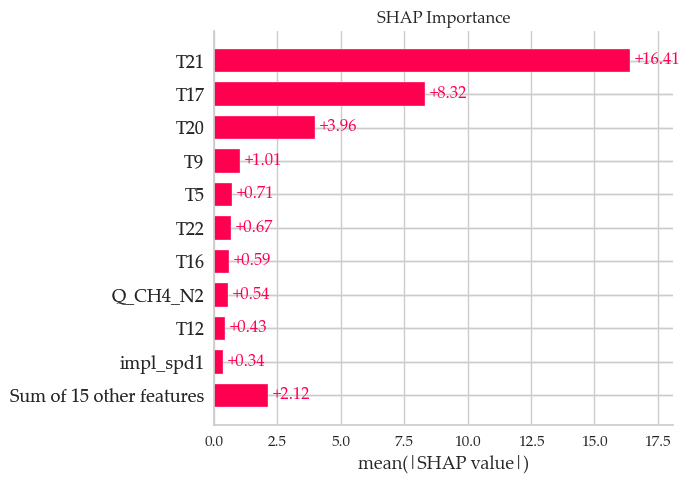

In [60]:
explainer = shap.Explainer(selector)
shap_importances = explainer(X_std)

shap.plots.bar(shap_importances, max_display=n+1, show=False)

plt.gcf().set_size_inches(7, n/2)
plt.title('SHAP Importance')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance.png', dpi = 300, transparent = True)
plt.show

###	Principal component analysis (PCA)

In [61]:
# Features PCA decomposition
n = 5  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

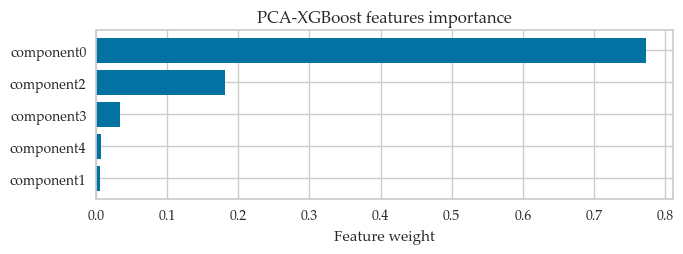

,importance
component1,0.004943
component4,0.007295
component3,0.033560
component2,0.181446
component0,0.772756


In [62]:
selector = xgb.XGBRegressor(objective=objective, eval_metric='mape', random_state=42)
selector.fit(X_dec, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_dec.columns).sort_values(by='importance', ascending=True)

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/PCA-Decomposed_feature_important.png', dpi = 300, transparent = True)
plt.title('PCA-XGBoost features importance')
plt.show()

feature_importances

###  Search learning objective

**(!)squarederror**  *the most narrative features* <br> 
<br>top 3 high weights
- MDI:  0.854238, 0.054071, 0.022287
- PI:   0.703757, 0.172862, 0.114753
- SHAP: 10.55, 1.82, 1.52
- PCA:  0.848779, 0.060443, 0.048946 (n = 5)

<br>top 10 strong feature
- MDI:  T20, T17, T9, T21, pump_spd, T16, O2, impl_spd1, I, T22
- PI:   T20, W, I, T9, T21, T17, T22, T16, T3, pump_spd
- SHAP: T20, Т9, Т17, Т21, I, Т16, W, T3, T22, O2    

general signs for MDI, PI and SHAP (9): **T22, T20, T21, T17, T16, T9, I, W** <br>

**squaredlogerror**
- MDI:  0.615026, 0.338410, 0.013796
- PI:   0.288100, 0.096523, 0.094404
- SHAP: 16.41, 8.32, 3.96
- PCA:  0.772756, 0.181446, 0.033560 (n = 5)
+
- MDI:   T17, T21, T20, T9, T31, impl_spd1, Q_CH4, T5, O2, pump_spd
- PI:    T21, T20, T17, T5, T9, Q_CH4_N2, O2, T22, impl_spd1, T12
- SHAP:  T21, T17, T20, T9, T5, T22, T16, Q_CH4_N2, T12, impl_spd1
 <br>
general signs for MDI, PI and SHAP (8): **T21, T17, T20, T12, T9, T5, impl_spd1** <br>

<br>**pseudohubererror**  *the best distribution of weights between features for MDI*
- MDI:  0.284817, 0.208115, 0.104297
- PI:   1764.165323, 1478.228442, 177.918050
- SHAP: 1232.55, 1222.17, 87.86
- PCA:  0.488028, 0.232588, 0.135599 (n = 5)
+
- MDI:  T20, T17, pump_spd, O2, Q_CH4, T12, T3, Q_CH4_N2, T7, impl_spd1
- PI:   T20, T17, T12, Q_CH4, T9, T16, Q_CH4_N2, pump_spd, T31
- SHAP: T17, T20, T25, T9, T16, Q_CH4_N2, T21, T3, impl_spd1, Q_CH4
 <br>
general signs for MDI, PI and SHAP (5): **T20, T17, Q_CH4, Q_CH4_N2**  <br>

<br>**(!)absoluteerror**  *the best distribution of weights between features for PI, PCA and SHAP* <br>
- MDI:  0.448591, 0.102074, 0.079580
- PI:   0.287426, 0.102639, 0.067397
- SHAP: 4.68, 3.37, 3.15
- PCA:  0.308782, 0.211287, 0.207408 (n = 5)
+ 
- MDI:  impl_spd1, T17, T20, T5, W, T9, I, T31, T21, T22
- PI:   T17, T20, T5, T9, T21, T25, Q_CH4_N2, pump_spd, T3, T23
- SHAP: T5, T17, T20, impl_spd1, T21, T31, T9, W, pump_spd, T22

general signs for MDI, PI and SHAP (7): **T17, T20, T5, T9, T21, W, impl_spd1**

# Fit models

## XGBoost

In [ ]:
# 7 variants:
# the most narrative features (squarederror)
# squaredlogerror
# the best distribution of weights between features for MDI (pseudohubererror)
# the best distribution of weights between features for PI, PCA and SHAP (absoluteerror)
# PCA (absoluteerror, 5 component)
# PCA (squarederror, 5 component)
# full feature set whis default XGBoost option

### variant 1 (squarederror)

In [65]:
%%time

X_train1 = X_train[['T22', 'T20', 'T21', 'T17', 'T16', 'T9', 'I', 'W']]
X_test1 = X_test[['T22', 'T20', 'T21', 'T17', 'T16', 'T9', 'I', 'W']]

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   },
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_train1, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 2min 47s
Wall time: 22.5 s


In [66]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test1)

print('squarederror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

squarederror
r2_score: 0.9960866831655701
MSE: 1.2858988096591528
MAE: 0.45179722583039666
MAPE: 4.07%


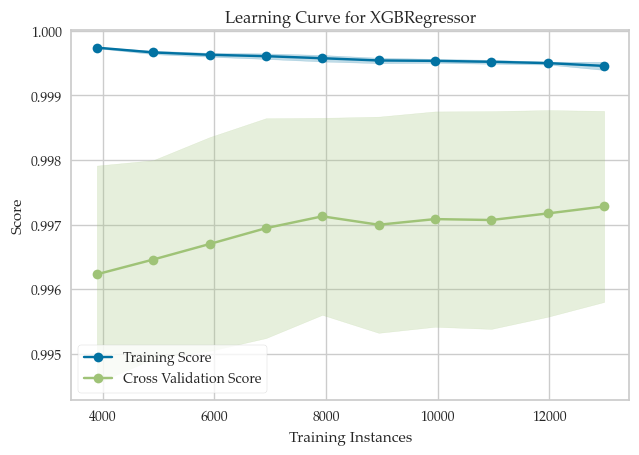

<AxesSubplot: title={'center': 'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [67]:
# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=42)
sizes = np.linspace(0.3, 1.0, 10)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(XGB_best, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=-1, size=(720, 480))
visualizer.fit(X_std,y)
visualizer.show()

### variant 2 (squaredlogerror)

In [72]:
%%time

X_train2 = X_train[['T21', 'T17', 'T20', 'T12', 'T9', 'T5', 'impl_spd1']]
X_test2 = X_test[['T21', 'T17', 'T20', 'T12', 'T9', 'T5', 'impl_spd1']]

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squaredlogerror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   },
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_train2, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 2min 47s
Wall time: 22.6 s


In [73]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test2)

print('squaredlogerror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

squaredlogerror
r2_score: 0.9780295790306229
MSE: 7.05391198977762
MAE: 1.404085987755839
MAPE: 5.25%


### variant 3 (pseudohubererror)

In [74]:
%%time

X_train3 = X_train[['T20', 'T17', 'Q_CH4', 'Q_CH4_N2']]
X_test3 = X_test[['T20', 'T17', 'Q_CH4', 'Q_CH4_N2']]

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:pseudohubererror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   },
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_train3, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 10, 'learning_rate': 0.01, 'max_depth': 5}
CPU times: total: 2min 21s
Wall time: 19.3 s


In [75]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test3)

print('pseudohubererror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

pseudohubererror
r2_score: 0.9766640158638075
MSE: 7.692903942070315
MAE: 1.2774482699483434
MAPE: 9.29%


### variant 4 (absoluteerror)

In [76]:
%%time

X_train4 = X_train[['T17', 'T20', 'T5', 'T9', 'T21', 'W', 'impl_spd1']]
X_test4 = X_test[['T17', 'T20', 'T5', 'T9', 'T21', 'W', 'impl_spd1']]

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   },
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_train4, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5}
CPU times: total: 10min 26s
Wall time: 1min 23s


In [77]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test4)

print('absoluteerror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

absoluteerror
r2_score: 0.987902938033441
MSE: 3.943018268005512
MAE: 0.8157674311628568
MAPE: 6.93%


### variant 5 (PCA, absoluteerror)

In [78]:
# Features PCA decomposition
n = 5  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

X_dec_train6, X_dec_test6, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=42)

In [79]:
%%time

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   }, 
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_dec_train6, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}


In [80]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_dec_test6)

print('PCA-absoluteerror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

PCA-absoluteerror
r2_score: 0.9906311028817028
MSE: 3.0555933882039885
MAE: 0.6291953036666968
MAPE: 9.73%


### variant 6 (PCA, squarederror)

In [89]:
# Features PCA decomposition
n = 6  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

X_dec_train7, X_dec_test7, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=42)

In [90]:
%%time

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   }, 
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_dec_train7, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 2min 35s
Wall time: 21.8 s


In [91]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_dec_test7)

print('PCA-quarederror',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

PCA-quarederror
r2_score: 0.9948147169366922
MSE: 1.7044694881475393
MAE: 0.44088825269094745
MAPE: 4.40%


### variant 7 (default)

In [84]:
%%time

XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42),
                        param_grid={
                                    'max_depth': range(2, 6),
                                    'learning_rate': [0.01, 0.1, 0.2],
                                    'gamma': [0, 0.1, 1, 10],
                                    #'min_child_weight': [0, 0.1, 1, 10]
                                   }, 
                        verbose=1,
                        cv=ShuffleSplit(n_splits=5, random_state=42))

XGB_grid.fit(X_train, y_train)
print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}


In [85]:
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test)

print('default XGBoost',
      f'r2_score: {r2_score(y_pred, y_test)}',
      f'MSE: {MSE(y_pred, y_test)}',
      f'MAE: {MAE(y_pred, y_test)}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default XGBoost
r2_score: 0.9970260019961286
MSE: 0.9792068782301675
MAE: 0.30900999086573977
MAPE: 2.82%
